In [ ]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os

def create_data_generators(data_dir, img_size=(256, 256), batch_size=32):
    """Create data generators with advanced augmentation"""
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        brightness_range=[0.7, 1.3],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )

    val_gen = test_datagen.flow_from_directory(
        os.path.join(data_dir, 'val'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_gen = test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, val_gen, test_gen

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, regularizers

def build_enhanced_model(num_classes=3, img_size=(256, 256)):
    """Build model with optimized architecture"""
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(*img_size, 3),
        pooling='avg'
    )

    # Freezing strategy
    for layer in base_model.layers[:150]:
        layer.trainable = False
    for layer in base_model.layers[150:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    inputs = layers.Input(shape=(*img_size, 3))
    x = base_model(inputs)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu',
                    kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, regularizers

def build_enhanced_efficientnet(num_classes=3, img_size=(224, 224)):

    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(*img_size, 3),
        pooling='avg'
    )

    for layer in base_model.layers[:150]:
        layer.trainable = False
    for layer in base_model.layers[150:]:
        layer.trainable = True

    inputs = layers.Input(shape=(*img_size, 3))
    x = base_model(inputs)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(512,
                   activation='relu',
                   kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    return model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard
)

def compile_model(model):
    """Compile with label smoothing and custom metrics"""
    optimizer = Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07
    )

    loss = tf.keras.losses.CategoricalCrossentropy(
        label_smoothing=0.1,
        from_logits=False
    )

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            tf.keras.metrics.AUC(name='auc', multi_label=True),
            tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

def get_callbacks():
    """Configure training callbacks"""
    return [
        EarlyStopping(
            monitor='val_auc',
            patience=15,
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            'best_model.keras',
            monitor='val_auc',
            save_best_only=True,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            mode='max',
            verbose=1
        ),
        TensorBoard(
            log_dir='./logs',
            histogram_freq=1,
            update_freq='epoch'
        )
    ]

In [ ]:
def train_and_evaluate():
    # 1. Prepare data
    DATA_DIR = "/content/drive/MyDrive/Manufacturing defects/enhanced_dataset"
    train_gen, val_gen, test_gen = create_data_generators(DATA_DIR)

    # 2. Build model
    model = build_enhanced_model()
    model.summary()

    # 3. Compile
    compile_model(model)

    # 4. Train
    history = model.fit(
        train_gen,
        epochs=30,
        validation_data=val_gen,
        callbacks=get_callbacks(),
        verbose=2
    )

    # 5. Evaluate
    print("\nEvaluating on test set...")
    test_results = model.evaluate(test_gen)
    print(f"Test Accuracy: {test_results[1]:.4f}")
    print(f"Test AUC: {test_results[2]:.4f}")

    return model, history

# Run training
model, history = train_and_evaluate()

Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,709,030 (17.96 MB)

 Trainable params: 3,946,139 (15.05 MB)

 Non-trainable params: 762,891 (2.91 MB)

Epoch 1/30
19/19 - 319s - 17s/step - accuracy: 0.3533 - auc: 0.5050 - loss: 8.7669 - precision: 0.3472 - recall: 0.2500 - val_accuracy: 0.3333 - val_auc: 0.5000 - val_loss: 8.3127 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/30
19/19 - 19s - 976ms/step - accuracy: 0.3617 - auc: 0.5173 - loss: 8.6243 - precision: 0.3446 - recall: 0.2200 - val_accuracy: 0.3333 - val_auc: 0.5046 - val_loss: 8.2172 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/30
19/19 - 18s - 962ms/step - accuracy: 0.3350 - auc: 0.5025 - loss: 8.5506 - precision: 0.3247 - recall: 0.2100 - val_accuracy: 0.3333 - val_auc: 0.5000 - val_loss: 8.1251 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/30
19/19 - 21s - 1s/step - accuracy: 0.3383 - auc: 0.5151 - loss: 8.4221 - precision: 0.3462 - recall: 0.2250 - val_accuracy: 0.3333 - val_auc: 0.5125 - val_loss: 8.0382 - val_precision: 0.0000e+00 - val_rec

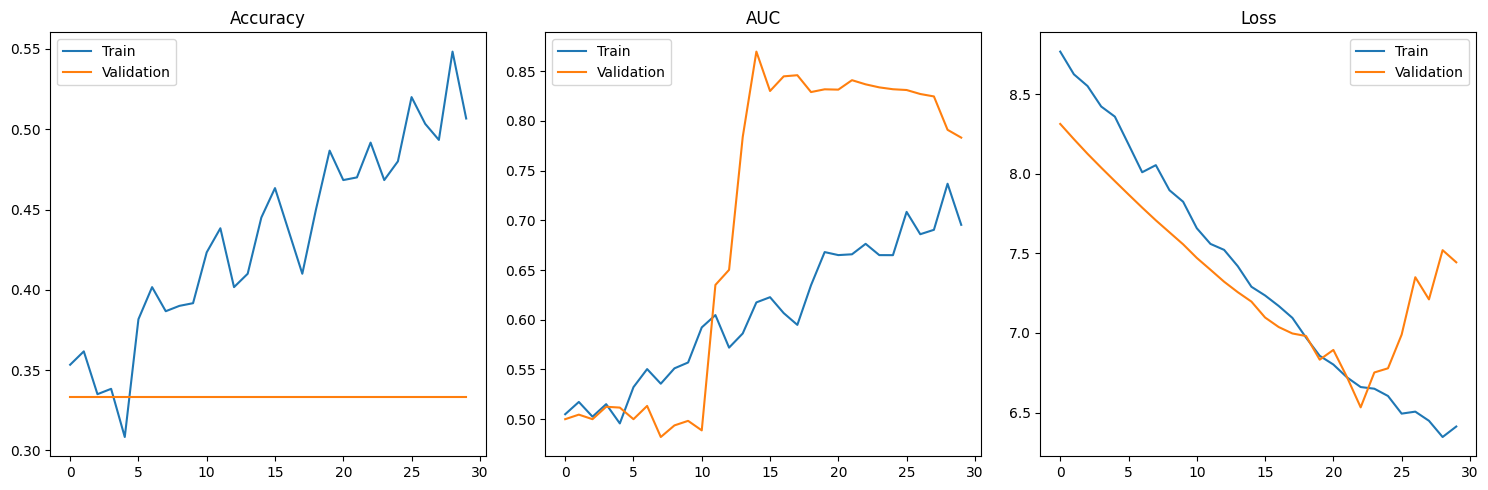

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


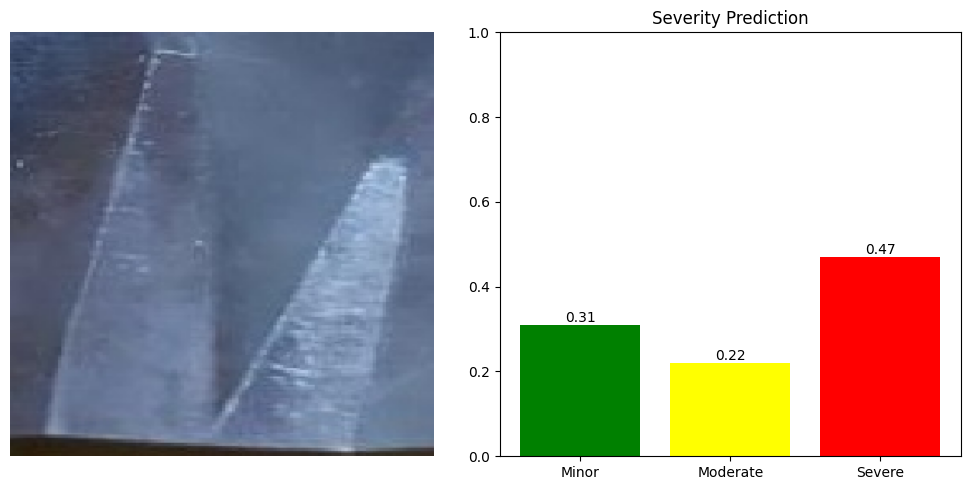

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training(history):
    """Plot training metrics"""
    plt.figure(figsize=(15, 5))

    # Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Accuracy')
    plt.legend()

    # AUC
    plt.subplot(1, 3, 2)
    plt.plot(history.history['auc'], label='Train')
    plt.plot(history.history['val_auc'], label='Validation')
    plt.title('AUC')
    plt.legend()

    # Loss
    plt.subplot(1, 3, 3)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def predict_and_visualize(model, image_path):
    """Make prediction with visualization"""
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)

    preds = model.predict(img_array)[0]
    class_names = ['Minor', 'Moderate', 'Severe']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    bars = plt.bar(class_names, preds, color=['green', 'yellow', 'red'])
    plt.ylim(0, 1)
    plt.title('Severity Prediction')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Example usage after training:
plot_training(history)
predict_and_visualize(model, "/content/drive/MyDrive/Manufacturing defects/sorted_defects/test/scratch/IMG_20230617_003840_jpg.rf.cd7ffd72179eebe10deec5086420cca9.jpg_defect_1.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
EfficientNet provides a severity score:

Minor → 0.31
Moderate → 0.22
Severe → 0.47

Confidence Score: 0.47


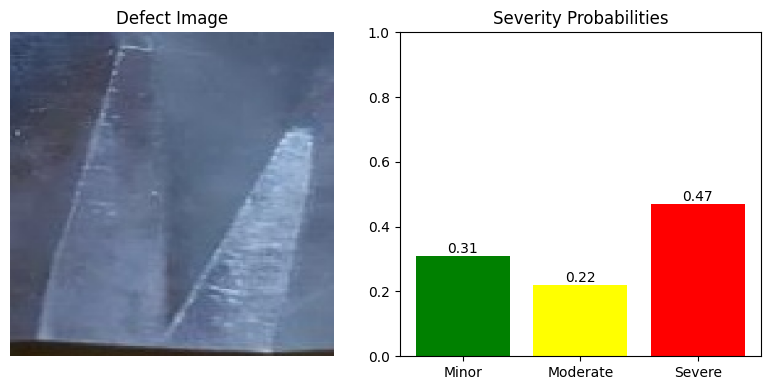

In [ ]:
def predict_severity(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)

    preds = model.predict(img_array)[0]
    confidence_score = max(preds)

    print("EfficientNet provides a severity score:\n")
    print(f"Minor → {preds[0]:.2f}")
    print(f"Moderate → {preds[1]:.2f}")
    print(f"Severe → {preds[2]:.2f}")
    print(f"\nConfidence Score: {confidence_score:.2f}")

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Defect Image')

    plt.subplot(1, 2, 2)
    classes = ['Minor', 'Moderate', 'Severe']
    colors = ['green', 'yellow', 'red']
    bars = plt.bar(classes, preds, color=colors)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

    plt.ylim(0, 1)
    plt.title('Severity Probabilities')
    plt.tight_layout()
    plt.show()

predict_severity(model, "/content/drive/MyDrive/Manufacturing defects/sorted_defects/test/scratch/IMG_20230617_003840_jpg.rf.cd7ffd72179eebe10deec5086420cca9.jpg_defect_1.jpg")

In [ ]:
# prompt: GIVE A CODE TO SAVE THE WHOLE MODEL

model.save('EFF_net.h5')
